# Analysis of M66

Date: 23 April 2025

In [1]:
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astroquery.mast import Observations
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip, mad_std
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import QTable

from photutils.utils import calc_total_error
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D, MedianBackground

from XRBID.Sources import (LoadSources, NewSources, GetCoords,
                           GetIDs, DaoClean, Crossref,
                           GetDaoPhots)
from XRBID.WriteScript import (WriteReg, WriteDS9, WriteScalings)
from XRBID.AutoPhots import RunPhots # Photometry
from XRBID.DataFrameMod import (Find, RemoveElse, FindUnique,
                                BuildFrame)
from XRBID.CMDs import MakeCMD, MakeCCD
from XRBID.Align import CorrectAstrometry, CalcPU, AlignReg # Astrometry

import seaborn as sns
sns.set_theme(style="dark")

In [2]:
cd = os.chdir
workdir = "/Users/undergradstudent/Research/XRB-Analysis/Notebooks"
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/HST/M66" # previously used as datadir
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66"

# Notes
$\textbf{Photometry}$:
- I had some trouble with using `RunPhots` to correctly detect sources. To cope with that, I started using `RunPhots` without the aperture_correction to save time. However, that did not lead anywhere either. Then, I started experimenting with `photutils.detection.DAOStarFinder` to detect the stars correctly. I had to use weird thresholds + fwhm for that code to work correctly. More explanation is mentioned under the `Manual Photometry` section.
- From a manual inspection of the F275W and F336W filters, it will be noticed that the images are very noisy and the quality of data is poor. The code for source detection is going to detect noise as sources. There isn't any way we can fix that. However, this should not be too big of a problem as this will be corrected later on.

$\textbf{Astrometry}$:
- Due to the poor quality of data, we will not be able to choose good calibrators for performing astrometric corrections. I will need to move on instead to finding positional uncertainties.

$\textbf{Catalogs}$
- Turns out that there are supernova remnants in M66 (see [link](https://en.wikipedia.org/wiki/Messier_66#Supernovae), [nasa/ipac](https://ned.ipac.caltech.edu/byname?objname=M66&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1)). Need to work on incorporating them. 
  
$\textbf{Misc}$:
- We will be moving on to JWST photometry after I create the CMD of this dataset.

# Mosaicking

I will first be doing mosaicking since that takes much longer. 

## Querying data

In [5]:
%%time

print("Finding observations for WFC3/UVIS images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="HST",
                                        filters=["F555W", "F814W", "F336W", "F438W", "F275W"],
                                        proposal_id=[11364, 13477, 15654, 12968],
                                        instrument_name="WFC3/UVIS")
print("Done")

Finding observations for WFC3/UVIS images...
Done
CPU times: user 29.2 ms, sys: 5.92 ms, total: 35.1 ms
Wall time: 23.4 s


In [7]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [9]:
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)
data_prod = ['FLC']       # other options are ['FLT','DRC','DRZ']
data_type = ['HAP-SVM']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")


 This may take several minutes... 

INFO: 37 of 74 products were duplicates. Only returning 37 unique product(s). [astroquery.mast.utils]
Done


In [10]:
# Gathering the FLC file names
input_flcs = glob.glob(os.path.join('mastDownload','HST','*','*.fits'))

# Moving files from mastDownload directory into current directory
for flc in input_flcs:
  shutil.copy(flc, os.path.basename(flc))

shutil.rmtree('mastDownload') # removes the extra directories
print("Done")

Done


In [12]:
# The filename format searched below will need to be changed based on the 
# names of the files downloaded above
flc_files = glob.glob("hst*_acs_wfc_*_j*_flc.fits")
flc_files.sort()       # Alphabetizing files

for i,f in enumerate(flc_files):
    try: hdu = fits.open(f)
    except: print(f,"not good. Please remove.")

print("Done")

Done


## F814W

In [ ]:
from drizzlepac import tweakreg
import glob

flc_files = glob.glob("hst*_wfc3_uvis_f814w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=True, writecat=True, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [ ]:
Woohoo! It worked! Let's see how the shifts look like:

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [3]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [4]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,0.36,0.75,0.008,1.00005,0.34,0.19
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.44,0.10,359.995,1.00023,0.32,0.14
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.56,0.60,0.001,1.00010,0.34,0.33
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.63,0.64,359.997,1.00007,0.33,0.29
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.79,0.81,0.000,0.99999,0.41,0.42
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.69,0.71,0.002,0.99999,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.82,0.80,0.002,0.99999,0.48,0.42
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.76,0.90,0.003,1.00000,0.44,0.41


In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)
# started at 3:53 pm

In [6]:
pwd

'/Users/undergradstudent/Research/XRB-Analysis/HST/M66'

In [7]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [8]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,1.04,0.75,0.000,1.00000,0.43,0.61
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.97,0.88,0.000,1.00000,0.45,0.41
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.89,0.94,0.000,1.00000,0.45,0.48
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.62,1.00,0.000,1.00000,0.55,0.41
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.48,0.49,0.000,1.00000,0.51,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.70,0.68,0.000,1.00000,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.94,0.70,0.000,1.00000,0.52,0.50
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.72,0.87,0.000,1.00000,0.51,0.52


In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f814w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

The drizzled image looks amazing!

## F555W

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [7]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f555w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [11]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.46,1.09,0.009,1.00007,0.57,0.38
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.91,0.87,359.989,0.99977,0.46,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,1.30,0.01,359.970,1.00011,0.41,0.51
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,-2.12,0.72,0.059,1.00067,0.44,0.48
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.32,0.50,0.004,1.00001,0.46,0.49
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.66,0.70,0.002,0.99994,0.52,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.58,0.63,0.002,0.99997,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.69,0.75,0.002,1.00001,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.93,0.68,0.004,0.99994,0.49,0.51


Since the rotation is quite small, I will rerun tweakreg with `fitgeometry='shift'`

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [12]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f555w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

This looks good too!

## F336W

In [ ]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f336w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f336w.txt', 
                  updatehdr=False)

In [13]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f336w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

## F438W

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f438w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f438w.txt', 
                  updatehdr=False)

In [17]:
shift_table = Table.read('M66_shifts_acs_f438w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f438w_ic0h01mj_flc.fits,0.79,0.84,0.000,1.00000,0.52,0.40
hst_12968_01_wfc3_uvis_f438w_ic0h01mk_flc.fits,0.80,1.29,0.000,1.00000,0.45,0.54
hst_12968_01_wfc3_uvis_f438w_ic0h01ml_flc.fits,0.44,0.56,0.000,1.00000,0.55,0.51
hst_12968_01_wfc3_uvis_f438w_ic0h01mm_flc.fits,1.20,0.75,0.000,1.00000,0.46,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22em_flc.fits,0.56,0.63,0.000,1.00000,0.51,0.49
hst_15654_22_wfc3_uvis_f438w_idxr22ez_flc.fits,0.47,0.40,0.000,1.00000,0.54,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22fc_flc.fits,0.82,0.79,0.000,1.00000,0.53,0.50


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f438w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

## F275W

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f275w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f275w.txt', 
                  updatehdr=False)

This worked! Need to see the outputs!

In [6]:
from astropy.table import Table
shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f275w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

Date: 24 April 2025

I was successful with creating the mosaics and the alignment also looks pretty good. I need to show these results to Qiana and see if things look good. 

Since my initial goal was mosaicking was to learn the procedure for creating mosaics, I had not downloaded the Chandra data. That is what I am going to do now. 

# Retrieving Chandra data

In [32]:
cd(chandradir)

In [57]:
TempSources = NewSources(infile="/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults.vot", rename=True,
                        outfile="/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame")

Reading in table from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults.vot
Enter new header names, or hit 'Enter' to keep name.



separation:  Separation
name:  CSC ID
ra:  RA
dec:  Dec
err_ellipse_r0:  Err Ellipse Major
err_ellipse_r1:  Err Ellipse Minor
err_ellipse_ang:  Err Ellipse Angle
significance:  Significance
likelihood_class:  Likelihood
conf_flag:  
sat_src_flag:  Saturation
streak_src_flag:  Streak
flux_aper_b:  Flux
flux_aper_lolim_b:  Flux lolim
flux_aper_hilim_b:  Flux hilim
flux_aper_w:  
flux_aper_lolim_w:  
flux_aper_hilim_w:  
flux_aper_avg_b:  
flux_aper_avg_lolim_b:  
flux_aper_avg_hilim_b:  
flux_aper_avg_w:  
flux_aper_avg_lolim_w:  
flux_aper_avg_hilim_w:  
theta_mean:  Theta
hard_hs:  HS Ratio
src_cnts_aper_b:  Counts
src_cnts_aper_lolim_b:  Counts lolim
src_cnts_aper_hilim_b:  Counts hilim


Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame...
DONE


In [25]:
# Will remove the index column 
TempSources = LoadSources("/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame")
display(TempSources)

outfile = "/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66.reg"

# Write to a DS9-compatible region file
WriteReg(TempSources, outfile=outfile, 
         idname="CSC ID", radius=50,
         width=2, color="hotpink",
         showlabel=True)


Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame...


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,2.158629e-14,2.700286e-14,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,2.096613e-14,2.689218e-14,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,2.943952e-14,3.440386e-14,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,2.366824e-13,2.788378e-13,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,5.671396e-15,8.390559e-15,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,2.248525e-15,4.208778e-15,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.359917e-15,7.956849e-15,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,3.837669e-14,4.670929e-14,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,1.775502e-15,4.142838e-15,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118


Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66.reg


In [27]:
Find(TempSources, "CSC ID = 2CXO J112014.1+125923")

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim
0,14.799625,2CXO J112014.1+125923,170.058772,12.989771,0.338092,0.335005,93.061016,4.722222,TRUE,False,...,4.268403e-15,6.561873e-15,NaN,NaN,NaN,0.375056,-0.204872,32.543934,25.652277,39.43559


# Photometry

In [ ]:
cd(hstdir)

I will be using `fwhm = 0.3''`

## F555W

In [15]:
cd(datadir)

### Manual Photometry
only to create a .reg file of the objects identified. 

I had written this code cell below a few days ago to see if I can detect the sources in a subset of the galaxy.

FWHM used: 3.0 Threshold used: 0.08654279119205667


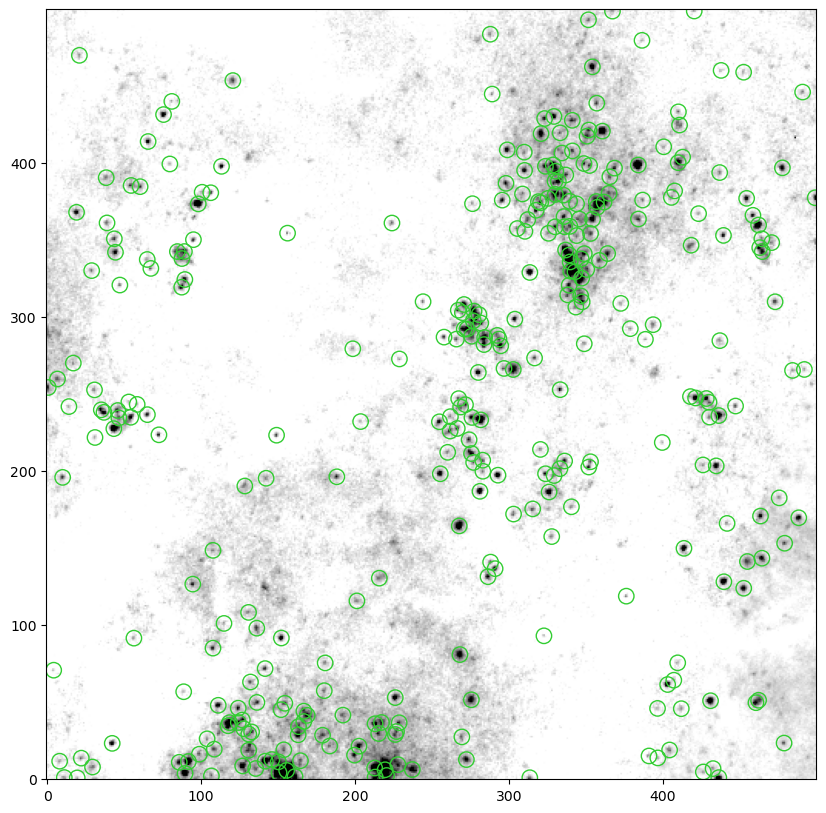

In [22]:
# modified code from https://github.com/devkhullar/querx-guide/blob/main/AstroHackWeek2022.ipynb

hdu = fits.open("M66_mosaic_acs_f555w_drc_sci.fits")
M66_cut = hdu[0].data[3500:4000, 1500:2000].astype(float)
M66_cut -= np.median(M66_cut)
bg_sig = mad_std(M66_cut)

# Defining parameters
fwhm = 3.0
threshold = 2.5 * bg_sig # got down from 5 to 2.5 by testing

print("FWHM used:", fwhm, 
      "Threshold used:", threshold)

# Detect Stars
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
daosource = daofind(M66_cut)
positions = np.transpose((daosource["xcentroid"], \
                          daosource["ycentroid"]))

# Create apertures around sources
apertures = CircularAperture(positions, r=5) 
# Plotting
plt.figure(figsize=(10,10))
plt.imshow(M66_cut, cmap="gray_r", origin="lower", \
          vmin=0, vmax=0.3)
apertures.plot(color="limegreen", lw=1)
plt.show()

<div class="alert-danger">
  <strong>Important Note</strong> The results that presented underneath are able to correctly identify the sources in the M66, with the f555w colour. However, I did not get the threshold or the fwhm that I am using by any direct means. 
    
The threshold I am using is found from the code, which I do not think should work for the entire dataset, but it for some reason is.

Additionally, the fwhm should also be incorrect. Using DS9, I found the `fwhm=0.3`, which should translate to $\sim7.57$ pixels. Yet `fwhm=3 pixels` works well for my code. 
</div>

In [47]:
data = fits.getdata('M66_mosaic_acs_f555w_drc_sci.fits')
daofind = DAOStarFinder(fwhm=3, threshold=0.08654279119205667)
objects = daofind(data)
objects

WriteReg(sources=[objects['xcentroid'], objects['ycentroid']],
         outfile='M66_f555w_test.reg', color='#00008B',
         radius=5)

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64
1,4983.439170701564,116.3405170764907,0.6572658901253249,0.16595249,-0.22487813005256507,25,0.32726532,1.6482096,-0.5425311,-1.259069703992667
2,4988.309487923568,117.39494254423923,0.41726696379296574,0.9192497,-0.2473477938088304,25,0.14138623,0.04429719,3.3840597,-1.1328006793134853
3,4918.2574106158445,135.5989645848628,0.7258021419146123,0.44212988,0.10402597067301561,25,0.34374323,1.7416567,-0.6024064,-1.4509149488930744
4,4887.936694208106,143.38139047608908,0.8726046059318067,0.35812506,0.41204547865373653,25,56.882866,130.90305,-5.2923746,-6.805305378659194
5,4864.125627989073,151.4908764170635,0.2135509703588125,-0.44122326,-0.9345087973699286,25,0.11408395,2.0783412,-0.79429215,-0.22132441033870653
6,4875.498539064048,152.36038362557798,0.568202344918729,0.6036022,-0.2260496734581023,25,1.1025295,6.73206,-2.07037,-2.6736441834561204
7,4842.9607135176375,157.9112580856924,0.8143868460877093,-0.97060794,-0.8485044121486719,25,0.28509635,3.2491853,-1.2794362,-0.4747864229098289
8,4838.690191171116,159.91790263433663,0.7321940370720005,-0.36554465,-0.19430945805785052,25,1.2758594,6.4075465,-2.0167294,-2.6806557569659235
9,4769.653834142535,181.00392659466544,0.6848580996831873,-0.91400284,-0.4684769024979746,25,0.25995207,3.3535833,-1.3137728,-0.46587606841039825


The above code has worked very well. However, there is a slight shift between the sources and the apertures in the image when I plot it in DS9. Let's align it correctly now.

I want to see what will happen if I use runphots with those parameters

In [3]:
cd(datadir)

In [17]:
hdu = fits.open("M66_mosaic_acs_f555w_drc_sci.fits")
threshold = 1.3717476520960825
RunPhots(hdu, gal="M66", instrument="WFC3", filter="F555W",
        fwhm_arcs=0.12, threshold=threshold,
         aperture_correction=False)
print("Done")

Running DaoFind. This may take a while...
Saving M66_daofind_f555w_wfc3_img.reg
Saving M66_daofind_f555w_wfc3_fk5.reg

 29959 sources found.
Background subtraction...
Photometry...
photometry_M66_f555w_wfc3_full.ecsv saved
Time for full photometry: 0.18419508139292398 minutes
Time for source photometry: 0.010700651009877523 minutes
Time for extended photometry: 0.012580434481302897 minutes
Calculating magnitudes...
photometry_M66_f555w_wfc3_sources.ecsv saved


UnboundLocalError: cannot access local variable 'apcorr_ext' where it is not associated with a value

This looks pretty good but there is still some problem with alignment. I will try to fix the alignment and then run it with `RunPhots`. 

Okay, so that run went in vain because of a small mistake. Let's do it again. 

In [ ]:
reg_correction = [1.085, 0.77]
threshold = 1.3717476520960825
fwhm_arcs = 0.12

RunPhots(hdu, gal="M66", instrument="WFC3", filter="F555W",
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=5)

The above one is better. 

Aperture Correction is finally complete!

I just read the part on the extended_rad parameter in `RunPhots`. I think `extended_rad=7` should look pretty good. I will consult with Qiana about that. I will also have more results to show to Qiana, and we can use the best of them all. 

In [ ]:
reg_correction = [1.085, 0.77]
threshold = 1.3717476520960825
fwhm_arcs = 0.12

RunPhots(hdu, gal="M66", instrument="WFC3", filter="F555W",
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=7)

## F814W
Date: 29 April 2025

In [ ]:
hdu = fits.open("M66_mosaic_acs_f814w_drc_sci.fits")

# Use parameters from run for F555W
reg_correction = [1.085, 0.77]
threshold = 1.3717476520960825
fwhm_arcs = 0.12

RunPhots(hdu, gal="M66", instrument="wfc3", filter="F814W", 
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=7)

In [ ]:
%%time
hdu = fits.open("M66_mosaic_acs_f814w_drc_sci.fits")

# Use parameters from run for F555W
reg_correction = [1.085, 0.77]
threshold = 1.3717476520960825
fwhm_arcs = 0.12

RunPhots(hdu, gal="M66", instrument="wfc3", filter="F814W", 
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=7)

## F438W

In [ ]:
%%time
hdu = fits.open("M66_mosaic_acs_f438w_drc_sci.fits")

# Use parameters from run for F555W
reg_correction = [1.085, 0.77]
threshold = 1.3717476520960825
fwhm_arcs = 0.12

RunPhots(hdu, gal="M66", instrument="wfc3", filter="F438W", 
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=6)

## F336

In [ ]:
%%time
hdu = fits.open("M66_mosaic_acs_f336w_drc_sci.fits")

# Use parameters from run for F555W
reg_correction = [1.085, 0.77]
threshold = 2.5
fwhm_arcs = 0.16

RunPhots(hdu, gal="M66", instrument="wfc3", filter="F336W", 
         fwhm_arcs=fwhm_arcs, threshold=threshold, num_stars=25,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=6)

## F275W

In [ ]:
%%time
hdu = fits.open("M66_mosaic_acs_f275w_drc_sci.fits")

# Use parameters from run for F555W
reg_correction = [1.085, 0.77]
fwhm_arcs = 0.16
threshold = 2.5

RunPhots(hdu, gal="M66", instrument="wfc3", filter="F275W", 
         fwhm_arcs=fwhm_arcs, num_stars=25, threshold=threshold,
         aperture_correction=True, reg_correction=reg_correction,
         extended_rad=6)

# Astrometric Corrections

Date: 5 May <br>
Still experimenting with astrometric corrections!

In [112]:
# Creating the region file of all the sources with the shifted coordinates
M66_CSC = LoadSources(chandradir+"/cscresults_M66_renamed.frame")
M66_unique = FindUnique(M66_CSC, header="CSC ID")

WriteReg(M66_unique, outfile=chandradir+"/M66_cscsources.reg", idname="CSC ID", 
         radius=5, width=2, color="hotpink", showlabel=True)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame...
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscsources.reg


This looks pretty good!

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_daofind_f555w_wfc3_fk5.reg


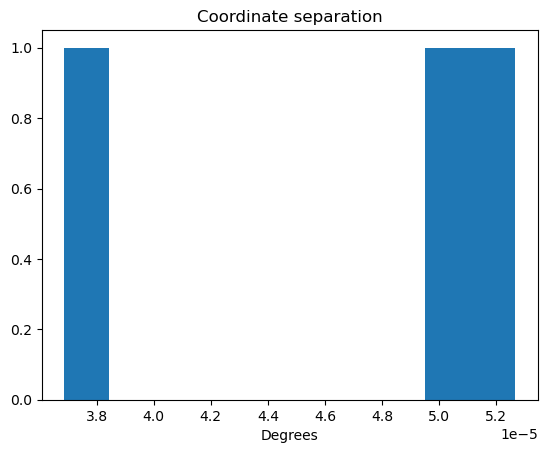

Median separation: 5.0286626037722936e-05


Input min and max separation: 3.66e-5, 5.25e-5


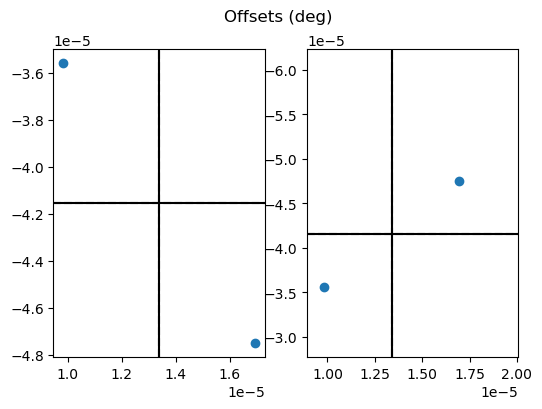

Median offsets in x and y (deg): 1.3385753376837783e-05 -4.154945661749565e-05


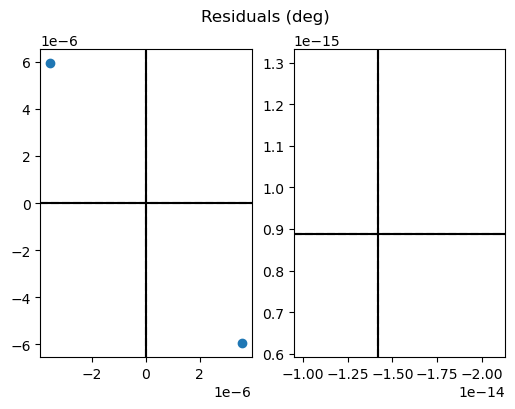


RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 1.3385753376837783e-05 -4.154945661749565e-05 degrees
 0.04818871215661602 -0.14957804382298434 arcsecs

Standard deviation in x and y offsets:
 3.5601731411816218e-06 5.948707189951108e-06 degrees
 0.012816623308253838 0.02141534588382399 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_astrocorrect.reg
Check region file for correct assessments.


(np.float64(1.3385753376837783e-05),
 np.float64(-4.154945661749565e-05),
 np.float64(3.5601731411816218e-06),
 np.float64(5.948707189951108e-06))

In [111]:
# Perform astrometric corrections
# Setting up the base and the catalog coordinates for CorrectAstrometry
base_coords = GetCoords(hstdir+"/M66_daofind_f555w_wfc3_fk5.reg")
cat_coords = [M66_calibrators["RA"].values.tolist(), 
              M66_calibrators["Dec"].values.tolist()]

# Running CorrectAstrometry
CorrectAstrometry(base_coords, cat_coords, returnshifts=True, \
                  savebasereg=hstdir+"/M66_astrocorrect.reg")

> **Warning**
median not smaller than std. need to add median offsets to chandra source positions

## Calculating Positional Uncertainty

In [113]:
sig1, sig2 = CalcPU(M66_unique, std=[0.01282,0.0214], # std in arcsecs
                    sig2search="Err Ellipse Major") 

In [114]:
M66_unique['1Sig'] = sig1  # Saves sig1 to a new header called '1Sig'
M66_unique['2Sig'] = sig2 

display(M66_unique)

M66_unique.to_csv(chandradir+'/M66_csc_astrocorrected.frame')

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.068475,0.150646
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.073583,0.165586
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.066353,0.145310
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.723391,3.446782
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.123175,0.291224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.429301,1.055527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.412932,1.005560
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.170969,0.359860
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.426755,1.050948


## Selecting the best 2-$\sigma$ radius per source

In [115]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_unique, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_unique, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M101_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandradir+"/M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.068475,0.150646
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.073583,0.165586
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.066353,0.145310
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.723391,3.446782
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.123175,0.291224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.429301,1.055527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.412932,1.005560
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.170969,0.359860
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.426755,1.050948


In [28]:
Find(M66_best, "CSC ID = 2CXO J112014.1+125923")

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,14.799625,2CXO J112014.1+125923,170.058772,12.989771,0.338092,0.335005,93.061016,4.722222,TRUE,False,...,0.375056,-0.204872,32.543934,25.652277,39.43559,0.130379,0.310416,3454.1559,3239.1051,6.208327


## Saving the positional uncertainties as region files

In [116]:
# Saving the 1 and 2 sigma region files for DS9 use.
# The 2sig region files have the CSC ID printed above each source.
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), radunit='arcsec', \
         idname="CSC ID", showlabel=True, outfile=chandradir+'/M66_bestrads_2sig.reg')
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), radunit='arcsec', \
         outfile=chandradir+'/M66_bestrads_1sig.reg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_bestrads_2sig.reg
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_bestrads_1sig.reg


# Identifying Optical Counterparts to X-ray Sources

In [22]:
# Pulling coordinate and ID information from region files
x, y = GetCoords(hstdir+"/M66_daofind_f555w_wfc3_img.reg")
ids = GetIDs(hstdir+"/M66_daofind_f555w_wfc3_img.reg")
ra, dec = GetCoords(hstdir+"/M66_daofind_f555w_wfc3_fk5.reg")

# Compiling into a single DataFrame
DaoFrame = BuildFrame(headers=['DaoID','X','Y','RA','Dec'], 
                      values=[ids,x,y,ra,dec])
DaoFrame.to_csv(chandradir+"/M66_daofind_wfc3_coords.frame")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_daofind_f555w_wfc3_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_daofind_f555w_wfc3_img.reg
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_daofind_f555w_wfc3_fk5.reg


In [23]:
DaoFrame = pd.read_csv(chandradir+"/M66_daofind_wfc3_coords.frame").drop("Unnamed: 0", axis=1)
display(DaoFrame)

,DaoID,X,Y,RA,Dec
0,1,4984.521740,117.111575,170.041484,12.955415
1,2,4989.403459,118.168805,170.041429,12.955427
2,3,4919.343214,136.371696,170.042221,12.955627
3,4,4889.021645,144.154041,170.042563,12.955713
4,5,4865.240935,152.261936,170.042831,12.955802
...,...,...,...,...,...
29954,29955,1650.323782,6685.159481,170.079143,13.027700
29955,29956,1778.724508,6684.769819,170.077693,13.027696
29956,29957,1774.594467,6687.012142,170.077740,13.027720
29957,29958,1625.957972,6689.278247,170.079419,13.027745


In [24]:
# Loading in the original DataFrame containing the best 2sig radii for each source
M66_best = LoadSources(chandradir+"/M66_csc_bestrads.frame")

# Reading in the newly-saved img region file
xsources, ysources = GetCoords(chandradir+"/M66_bestrads_2sig_img.reg")
# Adding the image coordinates to the DataFrame
M66_best["X"] = xsources
M66_best["Y"] = ysources

# Convert the radius from arcseconds to pixels. 
# The conversion is 0.05 for ACS/WFC and 0.03962 for WFC3/UVIS
M66_best["2Sig (pix)"] = M66_best["2Sig"] / 0.05 

# Saving the changes to the DataFrame
M66_best.to_csv(chandradir+"/M66_csc_bestrads.frame")
display(M66_best)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_csc_bestrads.frame...
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_bestrads_2sig_img.reg


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.420311,0.029981,173.048934,154.988228,191.109641,0.068475,0.150646,3130.4669,3395.69480,3.012914
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,0.412041,-0.277327,126.386565,109.441688,142.201784,0.073583,0.165586,3090.5900,3380.64090,3.311712
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.488407,0.224859,226.842541,209.119065,244.566017,0.066353,0.145310,3145.3955,3499.10130,2.906196
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.723391,3.446782,3020.9339,3458.73920,68.935649
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.477466,0.199875,39.229231,31.383385,46.639197,0.123175,0.291224,2980.7773,3462.48560,5.824477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,3.984317,0.201124,18.342335,13.057255,23.316527,0.429301,1.055527,-2626.7554,4502.10310,21.110531
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.338261,0.463460,24.421586,18.316189,30.526982,0.412932,1.005560,5523.0237,8885.71290,20.111193
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,4.414767,0.763273,150.478203,136.047662,164.908744,0.170969,0.359860,1421.5107,9217.86400,7.197200
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,3.872333,-0.408495,17.434501,12.141885,22.727118,0.426755,1.050948,-1623.5996,-646.76381,21.018958


In [25]:
DaoCleanFrame = DaoClean(daosources=DaoFrame, sources=M66_best,
                         sourceid="CSC ID", coordsys="img",
                         coordheads=['X','Y'], radheader="2Sig (pix)", wiggle=2) 


# Renaming the DaoID header to "F555W ID", to match the output of the other filters
DaoCleanFrame = DaoCleanFrame.rename(columns={'DaoID': 'F555W ID'})

display(DaoCleanFrame)

WriteReg(DaoCleanFrame, coordsys='fk5', width=2, 
         outfile=chandradir+'/M66_daoclean_f555w_acs_fk5.reg')

Cleaning DAOFind sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,F555W ID,X,Y,RA,Dec,CSC ID
0,15829,3126.747021,3396.139408,170.062465,12.991503,2CXO J112014.9+125929
1,15837,3129.162403,3396.728677,170.062438,12.99151,2CXO J112014.9+125929
2,15855,3126.421834,3398.637954,170.062469,12.991531,2CXO J112014.9+125929
3,15696,3089.206635,3378.651359,170.062889,12.991311,2CXO J112015.0+125928
4,15792,3028.026451,3389.708504,170.06358,12.991432,2CXO J112015.2+125932X
...,...,...,...,...,...,...
199,26446,1606.462918,4851.144019,170.079637,13.007515,2CXO J112019.0+130027
200,26479,1606.912352,4857.279775,170.079632,13.007583,2CXO J112019.0+130027
201,26487,1601.285274,4858.097251,170.079696,13.007592,2CXO J112019.0+130027
202,51,3862.045212,553.261388,170.054161,12.960216,2CXO J112013.0+125736


Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_daoclean_f555w_acs_fk5.reg


## Cross Referencing across filters

In [26]:
regions = [hstdir+"/M66_daofind_f275w_wfc3_img.reg",
           hstdir+"/M66_daofind_f336w_wfc3_img.reg",
           hstdir+"/M66_daofind_f438w_wfc3_img.reg",
           hstdir+"/M66_daofind_f814w_wfc3_img.reg"]

DaoCleanMatch = Crossref(DaoCleanFrame, 
                         regions=regions,
                         catalogs=['F275W','F336W','F438W','F814W'], coordheads=['X','Y'], 
                         sourceid="F555W ID",
                         outfile=chandradir+"/M66_daoclean_matches.frame")

DaoCleanMatch


Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID
0,3126.747021,3396.139408,15829,NaN,NaN,NaN,16481
1,3129.162403,3396.728677,15837,NaN,NaN,NaN,NaN
2,3126.421834,3398.637954,15855,NaN,NaN,NaN,16481
3,3126.421834,3398.637954,15855,NaN,NaN,NaN,16509
4,3089.206635,3378.651359,15696,67770,NaN,NaN,16305
...,...,...,...,...,...,...,...
229,1606.462918,4851.144019,26446,NaN,NaN,NaN,27454
230,1606.912352,4857.279775,26479,NaN,NaN,NaN,NaN
231,1601.285274,4858.097251,26487,NaN,NaN,NaN,NaN
232,3862.045212,553.261388,51,NaN,NaN,NaN,68


In [27]:
# Adding "CSC ID" to columns in DaoCleanMatch
DaoCleanMatch["CSC ID"] = None

# Adding the CSC IDs of each source the daosources are associated with
for i in range(len(DaoCleanMatch)): 
    # Searches for the CSC ID associated with each F555W ID (DaoID in DaoCleanFrame)
    tempid = DaoCleanMatch["F555W ID"][i] 
    tempcsc = Find(DaoCleanFrame, "F555W ID = " + str(tempid))["CSC ID"][0]
    DaoCleanMatch["CSC ID"][i] = tempcsc
    
# Updating the DataFrame
DaoCleanMatch.to_csv(chandradir+"/M66_daoclean_matches.frame")
display(DaoCleanMatch)

,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,CSC ID
0,3126.747021,3396.139408,15829,NaN,NaN,NaN,16481,2CXO J112014.9+125929
1,3129.162403,3396.728677,15837,NaN,NaN,NaN,NaN,2CXO J112014.9+125929
2,3126.421834,3398.637954,15855,NaN,NaN,NaN,16481,2CXO J112014.9+125929
3,3126.421834,3398.637954,15855,NaN,NaN,NaN,16509,2CXO J112014.9+125929
4,3089.206635,3378.651359,15696,67770,NaN,NaN,16305,2CXO J112015.0+125928
...,...,...,...,...,...,...,...,...
229,1606.462918,4851.144019,26446,NaN,NaN,NaN,27454,2CXO J112019.0+130027
230,1606.912352,4857.279775,26479,NaN,NaN,NaN,NaN,2CXO J112019.0+130027
231,1601.285274,4858.097251,26487,NaN,NaN,NaN,NaN,2CXO J112019.0+130027
232,3862.045212,553.261388,51,NaN,NaN,NaN,68,2CXO J112013.0+125736


In [28]:
# For each X-ray source, number the associated stars starting from 1.
tempcsc = DaoCleanMatch["CSC ID"][0] # Keeping track of the current X-ray source
DaoCleanMatch["StarID"] = None # Storing the star number for each X-ray source

starno = 1 # Star number counter

for i in range(len(DaoCleanMatch)): 
    # If this is a new CSC ID, save it to tempcsc and restart starno counter
    if tempcsc != DaoCleanMatch["CSC ID"][i]: 
        tempcsc = DaoCleanMatch["CSC ID"][i]
        starno = 1
    DaoCleanMatch["StarID"][i] = starno
    starno += 1 # adds one to the starno counter

# Saving the candidate region file with new numberings
WriteReg(DaoCleanMatch, coordsys="image", coordnames=["X","Y"], 
         idname="StarID", width=2, fontsize=12,
         showlabel=True, outfile=chandradir+"/M66_XRB_candidates.reg")

# DaoCleanMatch has now renumbered each star associated with 
# an X-ray source for simplicity
display(DaoCleanMatch)

Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_XRB_candidates.reg


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,CSC ID,StarID
0,3126.747021,3396.139408,15829,NaN,NaN,NaN,16481,2CXO J112014.9+125929,1
1,3129.162403,3396.728677,15837,NaN,NaN,NaN,NaN,2CXO J112014.9+125929,2
2,3126.421834,3398.637954,15855,NaN,NaN,NaN,16481,2CXO J112014.9+125929,3
3,3126.421834,3398.637954,15855,NaN,NaN,NaN,16509,2CXO J112014.9+125929,4
4,3089.206635,3378.651359,15696,67770,NaN,NaN,16305,2CXO J112015.0+125928,1
...,...,...,...,...,...,...,...,...,...
229,1606.462918,4851.144019,26446,NaN,NaN,NaN,27454,2CXO J112019.0+130027,2
230,1606.912352,4857.279775,26479,NaN,NaN,NaN,NaN,2CXO J112019.0+130027,3
231,1601.285274,4858.097251,26487,NaN,NaN,NaN,NaN,2CXO J112019.0+130027,4
232,3862.045212,553.261388,51,NaN,NaN,NaN,68,2CXO J112013.0+125736,1


## Incorporating Other Catalogs
[Whitemore et al.](https://academic.oup.com/mnras/article/520/1/63/6994548) created a cluster catalog for this galaxy which I will be incorporating in my work. 

<div class="alert alert-warning">
This did not end up working. I was not able to incorporate the catalog
</div>

In [3]:
cd("/Users/undergradstudent/Downloads/catalogs/")
hdu1 = fits.open("hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-cluster-class12.fits")
hdu2 = fits.open("hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-compact-association-class3.fits")
hdu3 = fits.open("hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-cluster-class12.fits")
hdu4 = fits.open("hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-compact-association-class3.fits")

In [78]:
cd("/Users/undergradstudent/Downloads/catalogs")

In [79]:
ls

hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-cluster-class12.fits
hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-compact-association-class3.fits
hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-cluster-class12.fits
hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-compact-association-class3.fits


In [8]:
# I am going to use this catalog for my work, confirm with qiana
t1 = QTable(hdu1[1].data)
t1

INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA,PHANGS_F275W_VEGA_ERR,PHANGS_F336W_VEGA,PHANGS_F336W_VEGA_ERR,PHANGS_F438W_VEGA,PHANGS_F438W_VEGA_ERR,PHANGS_F555W_VEGA,PHANGS_F555W_VEGA_ERR,PHANGS_F814W_VEGA,PHANGS_F814W_VEGA_ERR,PHANGS_F275W_mJy,PHANGS_F275W_mJy_ERR,PHANGS_F336W_mJy,PHANGS_F336W_mJy_ERR,PHANGS_F438W_mJy,PHANGS_F438W_mJy_ERR,PHANGS_F555W_mJy,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy,PHANGS_F814W_mJy_TOT_ERR,PHANGS_NON_DETECTION_FLAG,PHANGS_NO_COVERAGE_FLAG,PHANGS_CI,CC_CLASS
int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7
1,9,14,2875,6614.89,3239.51,170.06613550163783,12.939565672437887,1.0,4,0.6,20.64478245728906,0.02659657396351643,20.93979017654412,0.030188736564226437,22.250655300429276,0.031346415447021464,22.27859441730564,0.016875740045112282,22.11064764254441,0.03901893634778962,0.004894710575974825,0.00012002236400823634,0.005149012301279204,0.00014331060515183322,0.0051853476618246,0.00014985637672020489,0.004488303673158532,6.983200680382467e-05,0.003450014679669524,0.00012410973040724197,0.0,0.0,1.4406957552854887,ycl
2,31,46,958,7284.4,3396.34,170.05857517129016,12.94129168906165,1.0,1,1.0,24.105332415990546,0.37037020453020186,22.714208348075548,0.08964678639377795,22.519651769070073,0.027672450452808608,21.668955157650842,0.009359068435449567,20.217371142107172,0.008528855229104975,0.0002020724158307192,6.900054767200979e-05,0.0010045155423948492,8.302346398363295e-05,0.004047429496485954,0.00010326101122819036,0.007869333245767959,6.790160231908834e-05,0.01973020252367809,0.00015514284407774865,0.0,0.0,1.6525453388887816,outside
3,38,55,4336,6620.99,3457.63,170.0660666598804,12.941966204158541,1.0,1,1.0,22.281918510623996,0.07737770478364059,22.22169363119243,0.0616848745282317,22.46988424208646,0.027246659028787583,22.442268805930635,0.014600834523023043,21.98812430101322,0.02959330849684471,0.001083608980805747,7.730327650696346e-05,0.0015811116822482226,8.991884008849886e-05,0.0042372716090699316,0.00010644101884595907,0.003860223743174932,5.196364647241765e-05,0.003862160160097809,0.00010537395092536263,0.0,0.0,1.5549336132831346,outside
4,47,68,737,6698.34,3482.21,170.06519319571672,12.942236733359024,1.0,1,1.0,20.82626233865763,0.02611063539413167,20.81526062516283,0.022289843866434313,21.009603537555332,0.010733207751301713,20.91452051154636,0.006500915802188716,20.38050871921674,0.009989056907406837,0.004141284477435931,9.969238081274846e-05,0.005774784072017913,0.00011867308687031326,0.01626292222205026,0.00016093021202070686,0.015765646894598556,9.449216496329995e-05,0.01697760840966834,0.00015635452786221064,0.0,0.0,1.7234222094582332,map
5,61,90,2823,6745.89,3520.91,170.06465624597297,12.942662654573844,1.0,1,1.0,22.925218259744764,0.13452151333237802,22.27913233033862,0.06630949310249956,22.105464738627294,0.022063156905752657,21.881795724754113,0.012211765860952238,21.189383833152473,0.016662480049139786,0.0005991736362875742,7.431113649301165e-05,0.0014996401795385338,9.167950055632037e-05,0.005927261726618868,0.00012056776794817406,0.006468472112226721,7.282653409476053e-05,0.008059840858327328,0.00012381565857698675,0.0,0.0,1.8696595576630655,map
6,77,112,4480,6693.87,3573.16,170.06524368673834,12.943237687530972,1.0,1,0.9,22.420376006544206,0.08886691081023221,22.295399637807982,0.0638050159528756,22.434716534157765,0.02822564732648969,22.339074758333318,0.014652629751348428,21.885622773842176,0.028977814002450523,0.0009538708945819174,7.81518285312885e-05,0.001477338938900539,8.690493304831502e-05,0.004376766587349699,0.00011389555101401917,0.004245121225601391,5.7347585206615654e-05,0.0042445425390407

In [ ]:
t2 = QTable(hdu2[1].data)
t2

In [ ]:
t3 = QTable(hdu3[1].data)
t3

In [ ]:
t4 = QTable(hdu4[1].data)
t4

In [13]:
WhitCatalog = pd.DataFrame(data=[t1["PHANGS_X"], t1["PHANGS_Y"],
                                  t1["PHANGS_RA"], t1["PHANGS_DEC"]]).transpose()
WhitCatalog = WhitCatalog.rename(columns={0: 'X', 1: 'Y',
                                           2: 'RA', 3: 'DEC'})

WhitCatalog

,X,Y,RA,DEC
0,6614.89,3239.51,170.066136,12.939566
1,7284.40,3396.34,170.058575,12.941292
2,6620.99,3457.63,170.066067,12.941966
3,6698.34,3482.21,170.065193,12.942237
4,6745.89,3520.91,170.064656,12.942663
...,...,...,...,...
769,6948.57,10474.60,170.062368,13.019192
770,7652.35,10475.41,170.054418,13.019201
771,7564.38,10544.56,170.055412,13.019962
772,6132.20,10861.57,170.071589,13.023451


In [15]:
# The code below is not producing usable results. Likely a bug somewhere
# Saving the catalog
WriteReg(sources=WhitCatalog, coordsys="image", coordnames=["X","Y"], 
         width=2, fontsize=12, showlabel=True,
         outfile=chandradir+"/M66_Whit_Catalog_XRB_candidates_img.reg")

# encountered a bug below where the code got an error where WriteReg did not work
# when I had coordsys='fk5'. changed it to coordsys="FK5" for it to work. 
# The code below produces really big regions which arent usable
# WriteReg(sources=WhitCatalog, coordsys="FK5", coordnames=["RA","DEC"], 
#          width=2, fontsize=12, showlabel=True,
#          outfile=chandradir+"/M66_Whit_Catalog_XRB_candidates_fk5.reg")

Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_Whit_Catalog_XRB_candidates_img.reg
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_Whit_Catalog_XRB_candidates_fk5.reg


In [19]:
WriteReg(sources=WhitCatalog, coordsys="FK5", coordnames=["RA","DEC"], 
         radius=1, width=2, radunit='arcsec', fontsize=12, showlabel=True,
         outfile=chandradir+"/M66_Whit_Catalog_XRB_candidates_fk5.reg")

Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_Whit_Catalog_XRB_candidates_fk5.reg


In [24]:
# print("working")
# reffed_catalog = Crossref(DaoCleanMatch, regions=[chandradir+"/M66_Whit_Catalog_XRB_candidates_fk5.reg"],
#          catalogs=['Cluster'], coordheads=['RA', 'DEC'],
#          coordsys='fk5', search_radius=,
#          sourceid='CSC ID', outfile=chandradir+'/M66_XRB_candidates_post_catalogs.frame')
# print("done")


M66_best = LoadSources(chandradir+"/M66_csc_bestrads.frame")
DaoCleanFrame = Crossref(M66_best,
                         regions=[chandradir+"/M66_Whit_Catalog_XRB_candidates_img.reg"],
                          catalogs=['Cluster'],
                         sourceid="CSC ID", coordsys="img",
                         coordheads=['X','Y'], search_radius=M66_best["2Sig (pix)"].tolist(),
                         outfile=chandradir+"/crossreffed.frame") 

DaoCleanFrame
# Find(DaoCleanFrame, "Cluster ID != NaN")
# DaoClean

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_csc_bestrads.frame...
Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,X,Y,CSC ID,Cluster ID
0,3130.4669,3395.69480,2CXO J112014.9+125929,NaN
1,3090.5900,3380.64090,2CXO J112015.0+125928,NaN
2,3145.3955,3499.10130,2CXO J112014.9+125933,NaN
3,3020.9339,3458.73920,2CXO J112015.2+125932X,NaN
4,2980.7773,3462.48560,2CXO J112015.3+125932,NaN
...,...,...,...,...
83,-2626.7554,4502.10310,2CXO J112030.5+130013,NaN
84,5523.0237,8885.71290,2CXO J112008.5+130307,NaN
85,1421.5107,9217.86400,2CXO J112019.6+130320,NaN
86,-1623.5996,-646.76381,2CXO J112027.8+125649,NaN


In [47]:
pd.read_csv(chandradir+'/M66_XRB_candidates_post_catalogs.frame')

,Unnamed: 0,X,Y,CSC ID,Cluster ID
0,0,3126.747021,3396.139408,2CXO J112014.9+125929,NaN
1,1,3129.162403,3396.728677,2CXO J112014.9+125929,NaN
2,2,3126.421834,3398.637954,2CXO J112014.9+125929,NaN
3,3,3126.421834,3398.637954,2CXO J112014.9+125929,NaN
4,4,3089.206635,3378.651359,2CXO J112015.0+125928,NaN
...,...,...,...,...,...
229,229,1606.462918,4851.144019,2CXO J112019.0+130027,NaN
230,230,1606.912352,4857.279775,2CXO J112019.0+130027,NaN
231,231,1601.285274,4858.097251,2CXO J112019.0+130027,NaN
232,232,3862.045212,553.261388,2CXO J112013.0+125736,NaN


As expected after imaging the above regions with the XRB candidate regions, they do not have any overlappings.

# Classifying Optical Counterparts

I defined the following regions for this section: 

In [41]:
M66_best = LoadSources(chandradir+"/M66_csc_bestrads.frame")

# # Renaming each X-ray source as CXO001, CXO002, CXO003, etc. under header "ID"
M66_best["ID"] = ["CXO%03d" % (i+1) for i in range(len(M66_best))]

# Scalings that I am using
# 1.75 0.75 0.4 2524 3859 2351 4897
# 6.0 3.2 2.0 2632 3447 3032 3930

# Outputs a new scalings file 
WriteScalings(M66_best, outfile=chandradir+"/M66_XRB_scalings.txt", 
              scalings=chandradir+"/autoscalings.txt", idheader="ID")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_csc_bestrads.frame...
/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_XRB_scalings.txt saved
DONE.


In [42]:
# Have to manually change the path to DS9 in the .sh script to
# "/Applications/SAOImageDS9.app/Contents/MacOS/ds9"
WriteDS9(M66_best, galaxy="M66", zoom=6, 
         unique_scale=True, scales=chandradir+"/M66_XRB_scalings.txt",
         regions=[chandradir+"/M66_XRB_candidates.reg",
                  chandradir+"/M66_bestrads_1sig.reg", 
                  chandradir+"/M66_bestrads_2sig.reg"],
         colorfiles=[hstdir+"/M66_mosaic_acs_f814w_drc_sci.fits", 
                    hstdir+"/M66_mosaic_acs_f555w_drc_sci.fits", 
                    hstdir+"/M66_mosaic_acs_f438w_drc_sci.fits"], 
         basefilter=['green'], imgnames=chandradir+"/M66_XRB_candidates", 
         outfile=chandradir+"/M66_XRB_candidates.sh", idheader="ID", filetype="png")

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.029981,173.048934,154.988228,191.109641,0.068475,0.150646,3130.4669,3395.69480,3.012914,CXO001
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,-0.277327,126.386565,109.441688,142.201784,0.073583,0.165586,3090.5900,3380.64090,3.311712,CXO002
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.224859,226.842541,209.119065,244.566017,0.066353,0.145310,3145.3955,3499.10130,2.906196,CXO003
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,3329.616280,3231.522180,3427.710381,1.723391,3.446782,3020.9339,3458.73920,68.935649,CXO004
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.199875,39.229231,31.383385,46.639197,0.123175,0.291224,2980.7773,3462.48560,5.824477,CXO005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,0.201124,18.342335,13.057255,23.316527,0.429301,1.055527,-2626.7554,4502.10310,21.110531,CXO084
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,0.463460,24.421586,18.316189,30.526982,0.412932,1.005560,5523.0237,8885.71290,20.111193,CXO085
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,0.763273,150.478203,136.047662,164.908744,0.170969,0.359860,1421.5107,9217.86400,7.197200,CXO086
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,-0.408495,17.434501,12.141885,22.727118,0.426755,1.050948,-1623.5996,-646.76381,21.018958,CXO087


This part of the code is not complete yet.
Writing /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_XRB_candidates.sh...
DONE


In [47]:
cd(chandradir)
imgfiles = glob.glob("*_env.png")
imgfiles.sort()
goodxrbs = [i.split("_")[3] for i in imgfiles]

# Sets all X-ray sources as out-of-bounds by default
M66_best["Bounds"] = "Out"

# Then, sets the sources in the list above as within the bounds of the mosaic
for i in range(len(M66_best)): 
    if M66_best["ID"][i] in goodxrbs: 
        M66_best["Bounds"][i] = "In"


In [48]:
# Creating a DataFrame of good XRBs only
M66_xrbs = Find(M66_best, "Bounds = In")

# Adding empty columns that I'll use later
M66_xrbs["Class"] = ""
M66_xrbs["Best Star"] = ""
M66_xrbs["Mass"] = ""
M66_xrbs["Notes"] = ""

M66_notes = BuildFrame(headers=["CSC ID", "ID", "Class", 
                               "Best Star", "Mass", "Notes"], 
                       values=[M66_xrbs["CSC ID"], 
                               M66_xrbs["ID"], 
                               M66_xrbs["Class"], 
                               M66_xrbs["Best Star"], 
                               M66_xrbs["Mass"], 
                               M66_xrbs["Notes"]])

# Saving to a new .txt file. Can also use .frame
M66_notes.to_csv(chandradir+"/M66_XRB_testnotes.txt")

Notes from Classification
- Check CSC 4,
- Not sure whether 24 should be considered a cluster or a star.
- Same with 42. 42  ID'd as clusters
- 48 probably a galaxy
- 

ADD OBA
Set the middle ones as unknown

## Identifying SNR from X-ray properties.

In [40]:
def Lum(F, dist): 

	"""Calculates the luminosity of a set of sources given the flux and distance to the host galaxy. 

	PARAMETERS
	----------
	F	[list]	:	Flux of X-ray source(s), in units ergs/s/cm^2. 
	dist	[float]	:	Distance to the galaxy in units pc or cm.

	RETURNS
	---------
	L	[list]	:	List of luminosities in units ergs/s
	"""

	if not dist: dist = input("Galaxy distance (in pc, Mpc, or cm)? ")
	
	# if dist is less than 100, probably given in Mpcs. Convert to pcs.	
	if dist < 100: 
		dist = dist * 10**6
	
	# need dist in cm, since F is in ergs/s/cm2. If not given in cm, convert. 
	if dist < 1e18: 
		dist = dist * 3e18


	F = np.array(F)
	L = F*4*np.pi*(dist)**2	# luminosity calculation
	L = L.tolist()
	return L

In [41]:
luminosity = Lum(M66_best["Flux"], dist=9.620)
M66_best["Luminosity"] = luminosity
M66_best["log(Lx)"] = np.log10(M66_best["Luminosity"])
M66_best

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),Luminosity,log(Lx)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,173.048934,154.988228,191.109641,0.068475,0.150646,3130.4669,3395.69480,3.012914,2.551387e+38,38.406776
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,126.386565,109.441688,142.201784,0.073583,0.165586,3090.5900,3380.64090,3.311712,2.514555e+38,38.400461
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,226.842541,209.119065,244.566017,0.066353,0.145310,3145.3955,3499.10130,2.906196,3.341091e+38,38.523888
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,3329.616280,3231.522180,3427.710381,1.723391,3.446782,3020.9339,3458.73920,68.935649,NaN,NaN
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,39.229231,31.383385,46.639197,0.123175,0.291224,2980.7773,3462.48560,5.824477,7.399648e+37,37.869211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,18.342335,13.057255,23.316527,0.429301,1.055527,-2626.7554,4502.10310,21.110531,3.379276e+37,37.528824
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,24.421586,18.316189,30.526982,0.412932,1.005560,5523.0237,8885.71290,20.111193,6.502729e+37,37.813096
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,150.478203,136.047662,164.908744,0.170969,0.359860,1421.5107,9217.86400,7.197200,4.452773e+38,38.648631
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,17.434501,12.141885,22.727118,0.426755,1.050948,-1623.5996,-646.76381,21.018958,3.097223e+37,37.490972


>**Warning**
>
>I created the dataframe `snr_candidates` which have the properties which we are using to classifying a supernova candidate (log(Lx)<=37.5 and HS Ratio<=-0.75). I now need to incorporate this into the `M66_xrbs` dataframe so that the Class column in `M66_xrbs` show (SNR). I need to figure out a way to automate that. 


In [42]:
# Supernova remnant candidates
snr_candidates = Find(M66_best, criteria=['log(Lx)<=37.5','HS Ratio<=-0.75'])
snr_candidates

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),Luminosity,log(Lx)
0,8.100148,2CXO J112015.0+125921,170.062538,12.989251,0.417169,0.377474,174.326803,3.028571,TRUE,False,...,15.943878,10.528976,21.057952,0.175379,0.429209,3120.7320,3191.79620,8.584188,1.002238e+37,37.000971
1,8.748180,2CXO J112014.7+125937,170.061339,12.993597,0.373752,0.353781,175.324238,4.062500,TRUE,False,...,18.556035,12.922953,24.189117,0.175194,0.426666,3226.8526,3586.68520,8.533324,1.843201e+37,37.265573
2,45.142910,2CXO J112015.7+125845,170.065490,12.979281,0.496865,0.398594,114.179479,2.473684,MARGINAL,False,...,11.020259,6.367260,15.428362,0.211616,0.525363,2859.3343,2285.88160,10.507259,5.168464e+36,36.713361
3,55.540360,2CXO J112018.8+125932,170.078417,12.992199,0.355246,0.352550,100.025275,4.722222,TRUE,False,...,32.719170,25.790405,39.647935,0.154530,0.368895,1714.8599,3459.78650,7.377894,2.454810e+37,37.390018
4,56.010743,2CXO J112018.8+125924,170.078512,12.990211,0.382236,0.374887,10.207139,3.696970,TRUE,False,...,22.160068,15.984311,27.972545,0.182195,0.441425,1706.3950,3279.14500,8.828502,1.518614e+37,37.181448
5,62.781313,2CXO J112019.1+125947,170.079790,12.996356,0.568604,0.431156,177.945615,2.270270,TRUE,False,...,7.644581,4.266743,10.844639,0.314330,0.792960,1593.3415,3837.45440,15.859198,4.262150e+36,36.629629
6,64.596761,2CXO J112016.7+125830,170.069903,12.975028,0.432959,0.416387,110.602463,2.914286,TRUE,False,...,14.154013,9.158479,18.872017,0.207178,0.510079,2468.6005,1899.47710,10.201571,6.735086e+36,36.828343
7,68.719164,2CXO J112016.4+130034,170.068581,13.009677,0.898680,0.567040,149.540655,1.846154,TRUE,False,...,4.987571,2.182062,7.793080,0.413918,1.061367,2585.7502,5047.82750,21.227333,0.000000e+00,-inf
8,72.223544,2CXO J112019.5+125958,170.081516,12.999423,0.611480,0.514987,16.123950,2.545455,TRUE,False,...,8.080730,4.510175,11.651285,0.322053,0.811166,1440.5316,4116.12160,16.223320,2.521092e+36,36.401589
9,75.034310,2CXO J112014.8+125814,170.061855,12.970670,0.374988,0.359765,24.192297,4.315789,TRUE,False,...,27.572271,21.183574,33.960968,0.157553,0.378284,3181.1517,1503.46630,7.565688,2.086666e+37,37.319453


Date: 8 May 2025
Need to work on SNR classification

In [46]:
# for index, row in snr_candidates.iterrows():
#     print(row['CSC ID'], row['Luminosity'])

# for index1, row1 in M66_xrbs.iterrows():
#     for index2, row2 in snr_candidates.iterrows():
#         if row1["CSC ID"] == row2["CSC ID"]:
#             row1["Class"] = "(SNR)"

# testdf = M66_xrbs
# # after_supernova = testdf.merge(snr_candidates, left_on="CSC ID", right_on="CSC ID")
# # after_supernova
# after_supernova = snr_candidates.merge(testdf, left_on="CSC ID", right_on="CSC ID")
# after_supernova

M66_best["Class"] = None
for i in range (len(M66_best)):
    tempid = M66_best["CSC ID"][i]
    temp = Find(snr_candidates, "CSC ID = " + tempid)
    if len(temp) > 0:
        M66_best["Class"][i] = "(SNR)"



In [48]:
Find(M66_best, "(SNR)")  # Only works in class header

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),Luminosity,log(Lx),Class
0,8.100148,2CXO J112015.0+125921,170.062538,12.989251,0.417169,0.377474,174.326803,3.028571,TRUE,False,...,10.528976,21.057952,0.175379,0.429209,3120.7320,3191.79620,8.584188,1.002238e+37,37.000971,(SNR)
1,8.748180,2CXO J112014.7+125937,170.061339,12.993597,0.373752,0.353781,175.324238,4.062500,TRUE,False,...,12.922953,24.189117,0.175194,0.426666,3226.8526,3586.68520,8.533324,1.843201e+37,37.265573,(SNR)
2,45.142910,2CXO J112015.7+125845,170.065490,12.979281,0.496865,0.398594,114.179479,2.473684,MARGINAL,False,...,6.367260,15.428362,0.211616,0.525363,2859.3343,2285.88160,10.507259,5.168464e+36,36.713361,(SNR)
3,55.540360,2CXO J112018.8+125932,170.078417,12.992199,0.355246,0.352550,100.025275,4.722222,TRUE,False,...,25.790405,39.647935,0.154530,0.368895,1714.8599,3459.78650,7.377894,2.454810e+37,37.390018,(SNR)
4,56.010743,2CXO J112018.8+125924,170.078512,12.990211,0.382236,0.374887,10.207139,3.696970,TRUE,False,...,15.984311,27.972545,0.182195,0.441425,1706.3950,3279.14500,8.828502,1.518614e+37,37.181448,(SNR)
5,62.781313,2CXO J112019.1+125947,170.079790,12.996356,0.568604,0.431156,177.945615,2.270270,TRUE,False,...,4.266743,10.844639,0.314330,0.792960,1593.3415,3837.45440,15.859198,4.262150e+36,36.629629,(SNR)
6,64.596761,2CXO J112016.7+125830,170.069903,12.975028,0.432959,0.416387,110.602463,2.914286,TRUE,False,...,9.158479,18.872017,0.207178,0.510079,2468.6005,1899.47710,10.201571,6.735086e+36,36.828343,(SNR)
7,68.719164,2CXO J112016.4+130034,170.068581,13.009677,0.898680,0.567040,149.540655,1.846154,TRUE,False,...,2.182062,7.793080,0.413918,1.061367,2585.7502,5047.82750,21.227333,0.000000e+00,-inf,(SNR)
8,72.223544,2CXO J112019.5+125958,170.081516,12.999423,0.611480,0.514987,16.123950,2.545455,TRUE,False,...,4.510175,11.651285,0.322053,0.811166,1440.5316,4116.12160,16.223320,2.521092e+36,36.401589,(SNR)
9,75.034310,2CXO J112014.8+125814,170.061855,12.970670,0.374988,0.359765,24.192297,4.315789,TRUE,False,...,21.183574,33.960968,0.157553,0.378284,3181.1517,1503.46630,7.565688,2.086666e+37,37.319453,(SNR)


In [49]:
M66_best["SNR"] = 0
M66_best["Class"] = "(SNR)"
    

SyntaxError: invalid syntax (3532225604.py, line 2)

# Estimating XRB Masses with CMDs and CCDs

> **Warning**
> 
> When I make the CMDs, I am unable to plot the datapoints on the CMDs. Through manual inspection, I found that the dataframe columns for the filter all contain NaN values. This is likely due to the code below but, I still have not figured out what I am doing wrong here. 

In [15]:
DaoCleanMatch = LoadSources(chandradir+"/M66_daoclean_matches.frame")

# define parameters
dist = 9.62e6 # Mpc from https://ned.ipac.caltech.edu/byname?objname=M66&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
dmod = 5 * np.log10(dist) - 5
photfiles = [hstdir+"/photometry_M66_f555w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f275w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f336w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f438w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f814w_wfc3_sources.ecsv"]
idheads = ["F555W ID", "F275W ID", "F336W ID", "F438W ID", "F814W ID"]
filters = ["F555W", "F275W", "F336W", "F438W", "F814W"]
DaoCleanPhots = GetDaoPhots(DaoCleanMatch, photfiles=photfiles,
                           idheads=idheads, filters=filters,
                           magheader="aperture_mag_corr", dmod=dmod)
DaoCleanPhots

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_daoclean_matches.frame...
Searching /Users/undergradstudent/Research/XRB-Analysis/HST/M66/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/HST/M66/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/HST/M66/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/HST/M66/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/HST/M66/photometry_M66_f814w_wfc3_sources.ecsv


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,CSC ID,F555W,F275W,F336W,F438W,F814W
0,3126.747021,3396.139408,15829,NaN,NaN,NaN,16481.0,2CXO J112014.9+125929,-12.071404,NaN,NaN,NaN,-13.419425
1,3129.162403,3396.728677,15837,NaN,NaN,NaN,NaN,2CXO J112014.9+125929,-11.995069,NaN,NaN,NaN,NaN
2,3126.421834,3398.637954,15855,NaN,NaN,NaN,16481.0,2CXO J112014.9+125929,-12.054196,NaN,NaN,NaN,-13.419425
3,3126.421834,3398.637954,15855,NaN,NaN,NaN,16509.0,2CXO J112014.9+125929,-12.054196,NaN,NaN,NaN,-13.493090
4,3089.206635,3378.651359,15696,67770.0,NaN,NaN,16305.0,2CXO J112015.0+125928,-10.315686,-11.031006,NaN,NaN,-11.655035
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,1606.462918,4851.144019,26446,NaN,NaN,NaN,27454.0,2CXO J112019.0+130027,-5.529459,NaN,NaN,NaN,-6.846051
230,1606.912352,4857.279775,26479,NaN,NaN,NaN,NaN,2CXO J112019.0+130027,-5.502387,NaN,NaN,NaN,NaN
231,1601.285274,4858.097251,26487,NaN,NaN,NaN,NaN,2CXO J112019.0+130027,-5.598551,NaN,NaN,NaN,NaN
232,3862.045212,553.261388,51,NaN,NaN,NaN,68.0,2CXO J112013.0+125736,-4.671755,NaN,NaN,NaN,-6.192057


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F555W - F814W', ylabel='F555W'>)

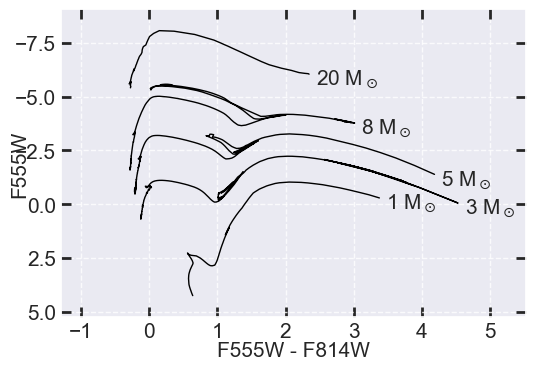

In [5]:
MakeCMD(xcolor=["F555W", "F814W"], ycolor="F555W")

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F435W - F814W', ylabel='F814W'>)

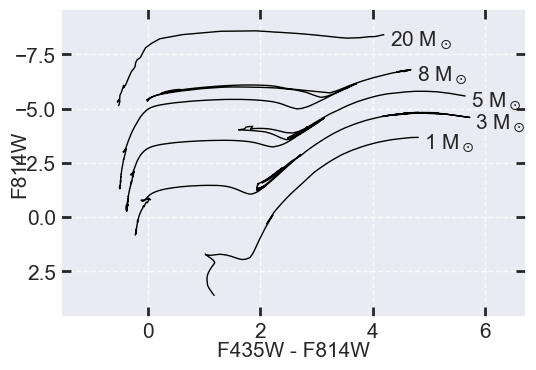

In [9]:
MakeCMD(xcolor=["F435W", "F814W"], ycolor="F814W")

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F555W - F814W', ylabel='F555W'>)

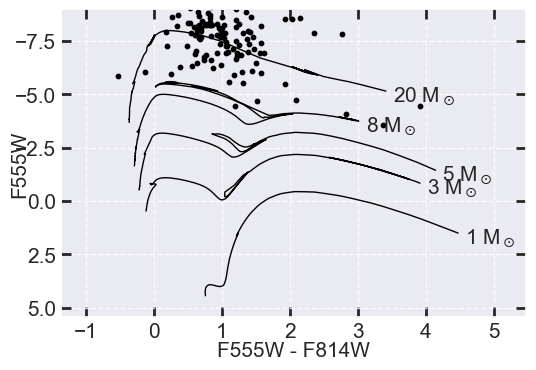

In [16]:
MakeCMD(DaoCleanPhots, xcolor=["F555W", "F814W"], ycolor="F555W", instrument='WFC3')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F438W - F814W', ylabel='F814W'>)

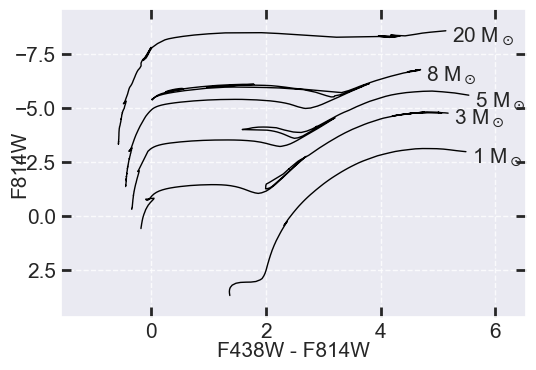

In [13]:
MakeCMD(DaoCleanPhots, xcolor=["F438W", "F814W"], ycolor="F814W", instrument='WFC3')

## Aging Clusters on a CCD

## Testing

In [7]:
# make data frameM66_daofind_f555w_wfc3_img.reg of green daofind sources
# regions: all other filters
green_sources_coords = GetCoords(hstdir+"/M66_daofind_f555w_wfc3_img.reg")
green_sources_ids = GetIDs(hstdir+"/M66_daofind_f555w_wfc3_img.reg")

green_sources = BuildFrame(values = [green_sources_ids, green_sources_coords[0], green_sources_coords[1]],
                           headers=["ID", "X", "Y"])
green_sources

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/M66_daofind_f555w_wfc3_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/M66_daofind_f555w_wfc3_img.reg


,ID,X,Y
0,1,4984.521740,117.111575
1,2,4989.403459,118.168805
2,3,4919.343214,136.371696
3,4,4889.021645,144.154041
4,5,4865.240935,152.261936
...,...,...,...
29954,29955,1650.323782,6685.159481
29955,29956,1778.724508,6684.769819
29956,29957,1774.594467,6687.012142
29957,29958,1625.957972,6689.278247


In [8]:
regions = [hstdir+"/M66_daofind_f275w_wfc3_img.reg",
           hstdir+"/M66_daofind_f336w_wfc3_img.reg",
           hstdir+"/M66_daofind_f438w_wfc3_img.reg",
           hstdir+"/M66_daofind_f814w_wfc3_img.reg"]
green = Crossref(green_sources,
                     regions=regions,
                      catalogs=['F275W', 'F336W', 'F438W', 'F814W'],
                     sourceid="ID", coordsys="img",
                     coordheads=['X','Y'], search_radius=3,
                     outfile="/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/green_source.frame") 

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


In [9]:
green

,X,Y,ID,F275W ID,F336W ID,F438W ID,F814W ID
0,4984.521740,117.111575,1,NaN,NaN,NaN,NaN
1,4989.403459,118.168805,2,NaN,NaN,NaN,NaN
2,4919.343214,136.371696,3,NaN,NaN,NaN,NaN
3,4889.021645,144.154041,4,NaN,NaN,NaN,NaN
4,4865.240935,152.261936,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
31685,1650.323782,6685.159481,29955,NaN,NaN,NaN,NaN
31686,1778.724508,6684.769819,29956,NaN,NaN,NaN,NaN
31687,1774.594467,6687.012142,29957,NaN,NaN,NaN,NaN
31688,1625.957972,6689.278247,29958,NaN,NaN,NaN,NaN


In [10]:
green["F555W ID"] = green["ID"]
green

,X,Y,ID,F275W ID,F336W ID,F438W ID,F814W ID,F555W ID
0,4984.521740,117.111575,1,NaN,NaN,NaN,NaN,1
1,4989.403459,118.168805,2,NaN,NaN,NaN,NaN,2
2,4919.343214,136.371696,3,NaN,NaN,NaN,NaN,3
3,4889.021645,144.154041,4,NaN,NaN,NaN,NaN,4
4,4865.240935,152.261936,5,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...
31685,1650.323782,6685.159481,29955,NaN,NaN,NaN,NaN,29955
31686,1778.724508,6684.769819,29956,NaN,NaN,NaN,NaN,29956
31687,1774.594467,6687.012142,29957,NaN,NaN,NaN,NaN,29957
31688,1625.957972,6689.278247,29958,NaN,NaN,NaN,NaN,29958


In [11]:
# DaoCleanMatch = LoadSources(chandradir+"/gre.frame")

# define parameters
dist = 9.62e6 # Mpc from https://ned.ipac.caltech.edu/byname?objname=M66&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
dmod = 5 * np.log10(dist) - 5
photfiles = [hstdir+"/photometry_M66_f555w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f275w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f336w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f438w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f814w_wfc3_sources.ecsv"]
idheads = ["F555W ID", "F275W ID", "F336W ID", "F438W ID", "F814W ID"]
filters = ["F555W", "F275W", "F336W", "F438W", "F814W"]
DaoCleanPhots_green = GetDaoPhots(green, photfiles=photfiles,
                           idheads=idheads, filters=filters,
                           magheader="aperture_mag_corr", dmod=dmod)
DaoCleanPhots_green

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f814w_wfc3_sources.ecsv


,X,Y,ID,F275W ID,F336W ID,F438W ID,F814W ID,F555W ID,F555W,F275W,F336W,F438W,F814W
0,4984.521740,117.111575,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,4989.403459,118.168805,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
2,4919.343214,136.371696,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
3,4889.021645,144.154041,4,NaN,NaN,NaN,NaN,4,-10.365924,NaN,NaN,NaN,NaN
4,4865.240935,152.261936,5,NaN,NaN,NaN,NaN,5,-5.304300,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31685,1650.323782,6685.159481,29955,NaN,NaN,NaN,NaN,29955,-8.105349,NaN,NaN,NaN,NaN
31686,1778.724508,6684.769819,29956,NaN,NaN,NaN,NaN,29956,-8.609613,NaN,NaN,NaN,NaN
31687,1774.594467,6687.012142,29957,NaN,NaN,NaN,NaN,29957,-8.985424,NaN,NaN,NaN,NaN
31688,1625.957972,6689.278247,29958,NaN,NaN,NaN,NaN,29958,-6.548451,NaN,NaN,NaN,NaN


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F438W - F814W', ylabel='F438W'>)

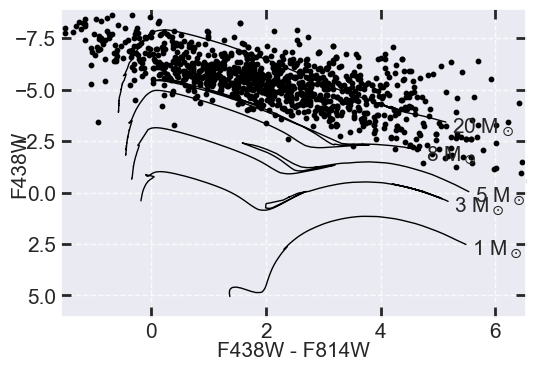

In [12]:
# MakeCMD(DaoCleanPhots_green, xcolor=["F438W", "F814W"], ycolor="F438W", instrument="WFC3")
MakeCMD(DaoCleanPhots_green, xcolor=["F438W", "F814W"], ycolor="F438W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F438W_CMD.png')
# MakeCMD(DaoCleanPhots_green, xcolor=["F555W", "F814W"], ycolor="F555W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F555W_CMD.png')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F555W - F814W', ylabel='F555W'>)

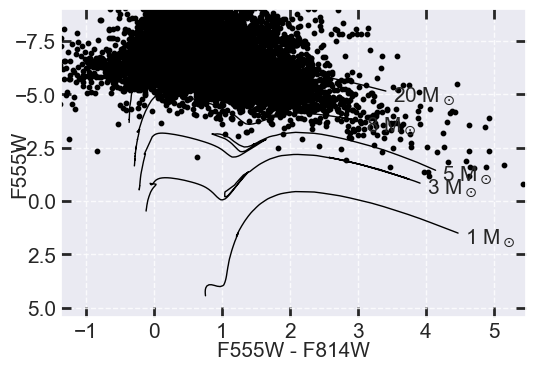

In [13]:
# MakeCMD(DaoCleanPhots_green, xcolor=["F555W", "F814W"], ycolor="F555W", instrument="WFC3")
# MakeCMD(DaoCleanPhots_green, xcolor=["F438W", "F814W"], ycolor="F438W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F438W_CMD.png')
MakeCMD(DaoCleanPhots_green, xcolor=["F555W", "F814W"], ycolor="F555W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F555W_CMD.png')

1. rerun astrometric corrections
2. create a ccd of daofind
3. run crossref on green sources (green filter) with all the stars
4. remove the source with X in the chandra catalog. remove it from everywhere (4th source in M66_best)
5. send qiana the code
6. GetDaoFrames
read what the instruments are used for 

27 May 2025
- saving the cmds above for meeting with alex and qiana.

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/M66_daoclean_matches.frame...
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f814w_wfc3_sources.ecsv


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F555W - F814W', ylabel='F555W'>)

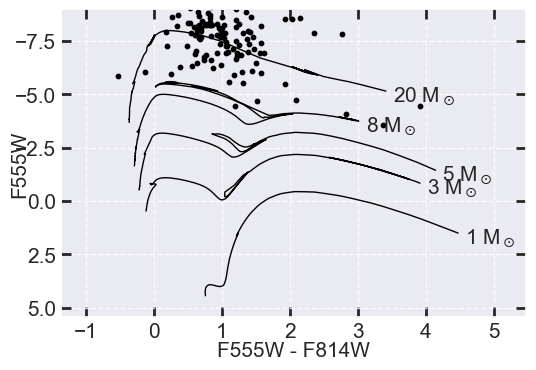

In [3]:
hstdir = '/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete'
DaoCleanMatch = LoadSources("/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/M66_daoclean_matches.frame")

# define parameters
dist = 9.62e6 # Mpc from https://ned.ipac.caltech.edu/byname?objname=M66&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
dmod = 5 * np.log10(dist) - 5
photfiles = [hstdir+"/photometry_M66_f555w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f275w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f336w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f438w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f814w_wfc3_sources.ecsv"]
idheads = ["F555W ID", "F275W ID", "F336W ID", "F438W ID", "F814W ID"]
filters = ["F555W", "F275W", "F336W", "F438W", "F814W"]
DaoCleanPhots = GetDaoPhots(DaoCleanMatch, photfiles=photfiles,
                           idheads=idheads, filters=filters,
                           magheader="aperture_mag_corr", dmod=dmod)
DaoCleanPhots
MakeCMD(DaoCleanPhots, xcolor=["F555W", "F814W"], ycolor="F555W", instrument='WFC3', save=True,
        savefile=hstdir+"/F555W_F814W_CMD.png")

In [6]:
# DaoCleanMatch = LoadSources(chandradir+"/gre.frame")

hstdir = '/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete'

green = LoadSources("/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/green_source.frame")
display(green)
# define parameters
dist = 9.62e6 # Mpc from https://ned.ipac.caltech.edu/byname?objname=M66&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
dmod = 5 * np.log10(dist) - 5
photfiles = [hstdir+"/photometry_M66_f555w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f275w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f336w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f438w_wfc3_sources.ecsv",
             hstdir+"/photometry_M66_f814w_wfc3_sources.ecsv"]
idheads = ["F555W ID", "F275W ID", "F336W ID", "F438W ID", "F814W ID"]
filters = ["F555W", "F275W", "F336W", "F438W", "F814W"]
DaoCleanPhots_green = GetDaoPhots(green, photfiles=photfiles,
                           idheads=idheads, filters=filters,
                           magheader="aperture_mag_corr", dmod=dmod)
# display(DaoCleanPhots_green)

# MakeCMD(DaoCleanPhots_green, xcolor=["F438W", "F814W"], ycolor="F438W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F438W_CMD.png')
# MakeCMD(DaoCleanPhots_green, xcolor=["F555W", "F814W"], ycolor="F555W", instrument="WFC3", save=True, savefile=hstdir+'green_F814W_F555W_CMD.png')

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/green_source.frame...


,X,Y,ID,F275W ID,F336W ID,F438W ID,F814W ID
0,4984.521740,117.111575,1,NaN,NaN,NaN,NaN
1,4989.403459,118.168805,2,NaN,NaN,NaN,NaN
2,4919.343214,136.371696,3,NaN,NaN,NaN,NaN
3,4889.021645,144.154041,4,NaN,NaN,NaN,NaN
4,4865.240935,152.261936,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
31685,1650.323782,6685.159481,29955,NaN,NaN,NaN,NaN
31686,1778.724508,6684.769819,29956,NaN,NaN,NaN,NaN
31687,1774.594467,6687.012142,29957,NaN,NaN,NaN,NaN
31688,1625.957972,6689.278247,29958,NaN,NaN,NaN,NaN


Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/photometry_M66_f555w_wfc3_sources.ecsv


KeyError: 'F555W ID'